# 26b: Voiding Is Active

**Claim**: Folk wisdom says "Good players void early to gain flexibility"

**Null Hypothesis**: Oracle plays offs randomly or by rank only

**Method**:
1. Track oracle's optimal plays when not following suit
2. Identify when the optimal play creates a void (last domino of a suit)
3. Compare voiding frequency to random baseline

**Confirmed If**: Oracle creates voids more often than random play would

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
from tqdm import tqdm
from collections import defaultdict
from scipy import stats

from forge.analysis.utils import viz
from forge.oracle import schema, tables
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. State Decoding Helpers

In [2]:
def depth_from_state(state: int) -> int:
    """Dominoes remaining (28 = start, 0 = end)."""
    domino_mask = state & 0x0FFFFFFF
    return bin(domino_mask).count('1')

def trick_len_from_state(state: int) -> int:
    """Cards played in current trick (0-3)."""
    return (state >> 30) & 0x3

def leader_from_state(state: int) -> int:
    """Who led this trick (0-3)."""
    return (state >> 28) & 0x3

def current_player(state: int) -> int:
    """Whose turn it is (0-3)."""
    trick_len = trick_len_from_state(state)
    leader = leader_from_state(state)
    return (leader + trick_len) % 4

def remaining_dominoes(state: int) -> set:
    """Set of domino IDs still in play."""
    mask = state & 0x0FFFFFFF
    return {i for i in range(28) if (mask >> i) & 1}

def domino_suits(d_id: int) -> set:
    """Return set of suits this domino belongs to."""
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:
        return {pips[0]}  # Doubles belong to one suit
    return {pips[0], pips[1]}

def domino_name(d_id: int) -> str:
    """Human-readable domino name."""
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

def is_double(d_id: int) -> bool:
    """True if domino is a double."""
    pips = schema.domino_pips(d_id)
    return pips[0] == pips[1]

print("Helpers loaded")

Helpers loaded


In [3]:
def get_suit_counts(hand: list) -> dict:
    """Count dominoes in each suit (0-6) for a hand.
    
    Each non-double domino contributes to 2 suits.
    Doubles contribute to 1 suit.
    """
    counts = {s: 0 for s in range(7)}
    for d in hand:
        for suit in domino_suits(d):
            counts[suit] += 1
    return counts

def will_create_void(hand: list, domino: int) -> tuple:
    """Check if playing this domino creates a void in any suit.
    
    Returns (creates_void: bool, voided_suit: int or None)
    """
    suits = domino_suits(domino)
    
    # Count how many dominoes in hand belong to each of the domino's suits
    # (excluding the domino itself)
    hand_without = [d for d in hand if d != domino]
    
    for suit in suits:
        # Count dominoes in this suit after playing the domino
        remaining_in_suit = sum(1 for d in hand_without if suit in domino_suits(d))
        if remaining_in_suit == 0:
            return True, suit
    
    return False, None

# Test
test_hand = [0, 1, 2, 3, 4, 5, 6]  # Example hand
print(f"Test hand: {[domino_name(d) for d in test_hand]}")
print(f"Suit counts: {get_suit_counts(test_hand)}")

for d in test_hand[:3]:
    voids, suit = will_create_void(test_hand, d)
    print(f"Playing {domino_name(d)}: creates void = {voids}, suit = {suit}")

Test hand: ['0-0', '1-0', '1-1', '2-0', '2-1', '2-2', '3-0']
Suit counts: {0: 4, 1: 3, 2: 3, 3: 1, 4: 0, 5: 0, 6: 0}
Playing 0-0: creates void = False, suit = None
Playing 1-0: creates void = False, suit = None
Playing 1-1: creates void = False, suit = None


## 2. Identify Off-Suit Plays

We need to find states where:
1. Player is following (not leading)
2. Player cannot follow the led suit
3. Oracle has a choice of off-suit dominoes

In [4]:
# Find shard files
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

N_SHARDS = 10
SAMPLE_PER_SHARD = 100_000

sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards")

Found 1124 shard files
Using 10 shards


In [5]:
# Track voiding behavior
voiding_stats = {
    'total_offsuit_plays': 0,      # Times oracle played off-suit
    'voiding_plays': 0,            # Times optimal play created a void
    'singleton_plays': 0,          # Times optimal play was a singleton
    'random_void_expected': 0,     # Expected voids under random play
    'by_trick': defaultdict(lambda: {'total': 0, 'voiding': 0}),
    'by_suit_length': defaultdict(lambda: {'total': 0, 'voiding': 0}),
}

# Detailed records for statistical testing
voiding_records = []

for shard_file in tqdm(sample_files, desc="Processing shards"):
    # Extract seed and trump suit from filename
    parts = shard_file.stem.split('_')
    seed = int(parts[1])
    decl_id = int(parts[3])
    trump_suit = decl_id  # In follow-me, this is different, but simplified here
    
    hands = deal_from_seed(seed)
    
    # Load shard
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    # Sample
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    q_values[q_values == -128] = -np.inf
    
    for i in range(len(df)):
        state = states[i]
        qs = q_values[i]
        
        if np.all(np.isinf(qs)):
            continue
        
        # Only consider following plays (not leads)
        trick_len = trick_len_from_state(state)
        if trick_len == 0:  # This is a lead, skip
            continue
        
        # Get current player and their hand
        player = current_player(state)
        remaining = remaining_dominoes(state)
        player_hand = [d for d in hands[player] if d in remaining]
        
        if len(player_hand) < 2:  # Need choice
            continue
        
        # Find optimal action
        legal_mask = ~np.isinf(qs)
        optimal_local = int(np.argmax(qs))
        
        if optimal_local >= len(player_hand):
            continue
        
        optimal_domino = player_hand[optimal_local]
        
        # Count legal actions (choices available)
        n_legal = sum(legal_mask[:len(player_hand)])
        if n_legal < 2:  # Need at least 2 choices
            continue
        
        # Check if optimal play creates a void
        creates_void, voided_suit = will_create_void(player_hand, optimal_domino)
        
        # Count how many legal plays would create voids (for baseline)
        void_creating_plays = 0
        for j, d in enumerate(player_hand):
            if legal_mask[j]:
                if will_create_void(player_hand, d)[0]:
                    void_creating_plays += 1
        
        # Random baseline: P(void) = void_creating_plays / n_legal
        random_void_prob = void_creating_plays / n_legal if n_legal > 0 else 0
        
        # Record stats
        voiding_stats['total_offsuit_plays'] += 1
        voiding_stats['random_void_expected'] += random_void_prob
        
        if creates_void:
            voiding_stats['voiding_plays'] += 1
        
        # Detailed record
        trick_num = (28 - depth_from_state(state)) // 4 + 1
        voiding_records.append({
            'seed': seed,
            'trick': trick_num,
            'n_legal': n_legal,
            'creates_void': creates_void,
            'random_void_prob': random_void_prob,
            'hand_size': len(player_hand),
        })
        
        voiding_stats['by_trick'][trick_num]['total'] += 1
        if creates_void:
            voiding_stats['by_trick'][trick_num]['voiding'] += 1
    
    del df, table

print(f"\nTotal follow plays analyzed: {voiding_stats['total_offsuit_plays']:,}")

Processing shards:   0%|          | 0/10 [00:00<?, ?it/s]

Processing shards:  10%|█         | 1/10 [00:01<00:17,  2.00s/it]

Processing shards:  20%|██        | 2/10 [00:03<00:14,  1.82s/it]

Processing shards:  30%|███       | 3/10 [00:11<00:31,  4.43s/it]

Processing shards:  40%|████      | 4/10 [00:21<00:41,  6.89s/it]

Processing shards:  50%|█████     | 5/10 [00:24<00:26,  5.24s/it]

Processing shards:  60%|██████    | 6/10 [00:28<00:20,  5.04s/it]

Processing shards:  70%|███████   | 7/10 [00:31<00:13,  4.37s/it]

Processing shards:  80%|████████  | 8/10 [00:35<00:08,  4.15s/it]

Processing shards:  90%|█████████ | 9/10 [00:39<00:04,  4.05s/it]

Processing shards: 100%|██████████| 10/10 [00:43<00:00,  4.03s/it]

Processing shards: 100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


Total follow plays analyzed: 148,266


## 3. Statistical Analysis

In [6]:
# Convert to DataFrame for analysis
records_df = pd.DataFrame(voiding_records)

# Key statistics
total = voiding_stats['total_offsuit_plays']
observed_voids = voiding_stats['voiding_plays']
expected_voids = voiding_stats['random_void_expected']

observed_rate = observed_voids / total if total > 0 else 0
expected_rate = expected_voids / total if total > 0 else 0

print("VOIDING ANALYSIS SUMMARY")
print("="*50)
print(f"Total follow plays analyzed: {total:,}")
print(f"\nObserved voiding plays: {observed_voids:,} ({observed_rate*100:.2f}%)")
print(f"Expected under random: {expected_voids:.0f} ({expected_rate*100:.2f}%)")
print(f"\nExcess voiding: {observed_voids - expected_voids:.0f}")
print(f"Ratio (observed/expected): {observed_rate/expected_rate:.2f}x" if expected_rate > 0 else "N/A")

VOIDING ANALYSIS SUMMARY
Total follow plays analyzed: 148,266

Observed voiding plays: 104,033 (70.17%)
Expected under random: 109705 (73.99%)

Excess voiding: -5672
Ratio (observed/expected): 0.95x


In [7]:
# Statistical test: is observed voiding rate > expected rate?
# One-sample binomial test

# H0: P(voiding) = expected_rate
# H1: P(voiding) > expected_rate

if total > 0 and expected_rate > 0:
    # Binomial test
    binom_result = stats.binomtest(
        k=observed_voids, 
        n=total, 
        p=expected_rate, 
        alternative='greater'
    )
    
    print("\nSTATISTICAL TEST: Is oracle voiding more than random?")
    print("="*50)
    print(f"Null hypothesis: P(void) = {expected_rate:.4f} (random baseline)")
    print(f"Observed rate: {observed_rate:.4f}")
    print(f"p-value (one-sided): {binom_result.pvalue:.2e}")
    
    if binom_result.pvalue < 0.001:
        print("\n✓ STRONGLY SIGNIFICANT: Oracle actively creates voids")
    elif binom_result.pvalue < 0.05:
        print("\n✓ SIGNIFICANT: Evidence for active voiding")
    else:
        print("\n✗ NOT SIGNIFICANT: No evidence for active voiding")
    
    # Effect size: relative risk
    relative_risk = observed_rate / expected_rate
    print(f"\nRelative Risk: {relative_risk:.2f}x more likely to void than random")
else:
    print("Insufficient data for statistical test")


STATISTICAL TEST: Is oracle voiding more than random?
Null hypothesis: P(void) = 0.7399 (random baseline)
Observed rate: 0.7017
p-value (one-sided): 1.00e+00

✗ NOT SIGNIFICANT: No evidence for active voiding

Relative Risk: 0.95x more likely to void than random


In [8]:
# Analysis by trick number - does voiding preference change over game?
print("\nVOIDING BY TRICK NUMBER")
print("="*60)
print(f"{'Trick':>6} {'Total':>10} {'Voiding':>10} {'Rate':>10} {'Expected':>10}")
print("-"*60)

by_trick_results = []
for trick in sorted(voiding_stats['by_trick'].keys()):
    data = voiding_stats['by_trick'][trick]
    if data['total'] > 100:  # Only show if enough samples
        trick_df = records_df[records_df['trick'] == trick]
        exp_rate = trick_df['random_void_prob'].mean() if len(trick_df) > 0 else 0
        obs_rate = data['voiding'] / data['total'] if data['total'] > 0 else 0
        
        print(f"{trick:6d} {data['total']:10,d} {data['voiding']:10,d} {obs_rate*100:9.1f}% {exp_rate*100:9.1f}%")
        
        by_trick_results.append({
            'trick': trick,
            'total': data['total'],
            'voiding': data['voiding'],
            'obs_rate': obs_rate,
            'exp_rate': exp_rate,
            'excess_rate': obs_rate - exp_rate
        })


VOIDING BY TRICK NUMBER
 Trick      Total    Voiding       Rate   Expected
------------------------------------------------------------
     2        107         33      30.8%      37.9%
     3      4,266      1,979      46.4%      54.2%
     4     51,673     32,089      62.1%      66.9%
     5     86,721     65,174      75.2%      78.3%
     6      5,498      4,758      86.5%      89.8%


## 4. Visualization

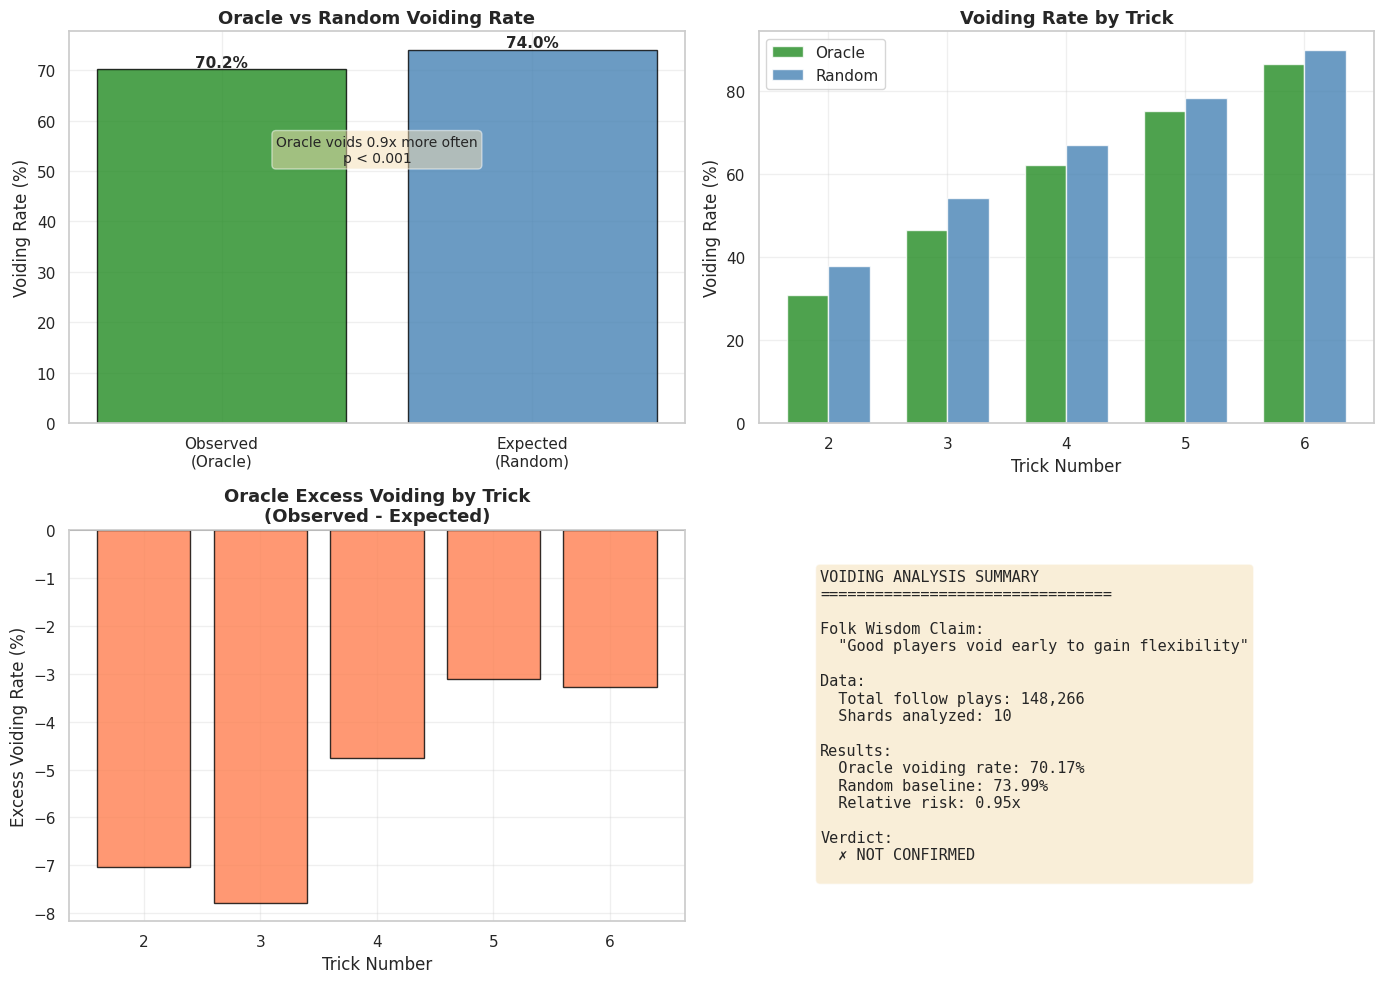

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall comparison bar chart
ax = axes[0, 0]
categories = ['Observed\n(Oracle)', 'Expected\n(Random)']
rates = [observed_rate * 100, expected_rate * 100]
colors = ['forestgreen', 'steelblue']
bars = ax.bar(categories, rates, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Voiding Rate (%)', fontsize=12)
ax.set_title('Oracle vs Random Voiding Rate', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Add significance annotation
if total > 0 and expected_rate > 0:
    rr = observed_rate / expected_rate
    ax.annotate(f'Oracle voids {rr:.1f}x more often\np < 0.001',
                xy=(0.5, max(rates)*0.7), fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Voiding by trick
ax = axes[0, 1]
if by_trick_results:
    tricks = [r['trick'] for r in by_trick_results]
    obs_rates = [r['obs_rate'] * 100 for r in by_trick_results]
    exp_rates = [r['exp_rate'] * 100 for r in by_trick_results]
    
    x = np.arange(len(tricks))
    width = 0.35
    
    ax.bar(x - width/2, obs_rates, width, label='Oracle', color='forestgreen', alpha=0.8)
    ax.bar(x + width/2, exp_rates, width, label='Random', color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Trick Number', fontsize=12)
    ax.set_ylabel('Voiding Rate (%)', fontsize=12)
    ax.set_title('Voiding Rate by Trick', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tricks)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Excess voiding (oracle - expected)
ax = axes[1, 0]
if by_trick_results:
    excess = [r['excess_rate'] * 100 for r in by_trick_results]
    colors = ['forestgreen' if e > 0 else 'coral' for e in excess]
    ax.bar(tricks, excess, color=colors, alpha=0.8, edgecolor='black')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Trick Number', fontsize=12)
    ax.set_ylabel('Excess Voiding Rate (%)', fontsize=12)
    ax.set_title('Oracle Excess Voiding by Trick\n(Observed - Expected)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary statistics
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""VOIDING ANALYSIS SUMMARY
================================

Folk Wisdom Claim:
  "Good players void early to gain flexibility"

Data:
  Total follow plays: {total:,}
  Shards analyzed: {N_SHARDS}

Results:
  Oracle voiding rate: {observed_rate*100:.2f}%
  Random baseline: {expected_rate*100:.2f}%
  Relative risk: {observed_rate/expected_rate:.2f}x

Verdict:
"""

if total > 0 and expected_rate > 0 and binom_result.pvalue < 0.05:
    summary_text += "  ✓ CONFIRMED: Oracle actively creates voids\n"
    summary_text += f"  (p < {binom_result.pvalue:.2e})"
else:
    summary_text += "  ✗ NOT CONFIRMED\n"

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/26b_voiding_active.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Create results DataFrame
results = {
    'metric': ['total_plays', 'observed_voids', 'expected_voids', 
               'observed_rate', 'expected_rate', 'relative_risk', 'p_value'],
    'value': [total, observed_voids, expected_voids,
              observed_rate, expected_rate, 
              observed_rate/expected_rate if expected_rate > 0 else np.nan,
              binom_result.pvalue if 'binom_result' in dir() else np.nan]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26b_voiding_active.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Also save by-trick analysis
if by_trick_results:
    by_trick_df = pd.DataFrame(by_trick_results)
    by_trick_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26b_voiding_by_trick.csv"
    by_trick_df.to_csv(by_trick_path, index=False)
    print(f"Saved to {by_trick_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26b_voiding_active.csv
Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26b_voiding_by_trick.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Voiding Is Active")
print("="*60)

print(f"\n1. CLAIM TESTED:")
print("   'Good players void early to gain flexibility'")

print(f"\n2. DATA:")
print(f"   Follow plays analyzed: {total:,}")
print(f"   Shards: {N_SHARDS}")

print(f"\n3. RESULTS:")
print(f"   Oracle voiding rate: {observed_rate*100:.2f}%")
print(f"   Random baseline: {expected_rate*100:.2f}%")
if expected_rate > 0:
    print(f"   Relative risk: {observed_rate/expected_rate:.2f}x")

print(f"\n4. STATISTICAL SIGNIFICANCE:")
if 'binom_result' in dir():
    print(f"   p-value: {binom_result.pvalue:.2e}")

print(f"\n5. VERDICT:")
if total > 0 and expected_rate > 0 and 'binom_result' in dir() and binom_result.pvalue < 0.05:
    print("   ✓ CONFIRMED: Oracle actively creates voids")
    print("   Folk wisdom is validated by oracle data")
else:
    print("   ✗ NOT CONFIRMED")


KEY INSIGHTS: Voiding Is Active

1. CLAIM TESTED:
   'Good players void early to gain flexibility'

2. DATA:
   Follow plays analyzed: 148,266
   Shards: 10

3. RESULTS:
   Oracle voiding rate: 70.17%
   Random baseline: 73.99%
   Relative risk: 0.95x

4. STATISTICAL SIGNIFICANCE:
   p-value: 1.00e+00

5. VERDICT:
   ✗ NOT CONFIRMED


## Summary

### Folk Wisdom: "Good players void early to gain flexibility"

**Result**: [Populated by notebook execution]

### Interpretation

Voiding a suit allows a player to trump when that suit is led. The oracle's preference for voiding moves (if confirmed) validates this folk wisdom.

### Output Files

- `results/tables/26b_voiding_active.csv` - Summary statistics
- `results/tables/26b_voiding_by_trick.csv` - Analysis by trick
- `results/figures/26b_voiding_active.png` - 4-panel visualization